In [1]:
# !pip install -qU python-gdcm pydicom pylibjpeg
# !pip install -U pylibjpeg-libjpeg -v
# !pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
# !pip install pydicom

# import include nesscessaryz
import cv2
from PIL import Image, ImageOps
import argparse
import os
import glob
import matplotlib.pyplot as plt
import multiprocessing as mp
from joblib import Parallel, delayed
import pydicom
import time
import numpy as np
import torch
import random
import pandas as pd
from pydicom.pixel_data_handlers import apply_windowing
import imageio
import time
import shutil

# Processing data RSNA

In [2]:

1024 * 1024 * 3

3145728

In [3]:
meta_rsna = pd.read_csv(r"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\RSNA_NOSIZE\train.csv")

In [4]:
meta_rsna = meta_rsna[meta_rsna.view.isin(['CC', 'MLO'])].reset_index()

In [5]:
meta_rsna

,index,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54663,54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54664,54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54665,54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54666,54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [12]:
import numpy as np
import pandas as pd
import multiprocessing as mp
class Setting_data:
    def __init__(self, data):
        
        self.data= data[['patient_id', 'image_id', 'view', 'laterality','cancer']]
        
        self.id = 0
        self.par = 0
        self.group = None
        
        
        self.meta_pro = pd.DataFrame(columns=['patient_id', 'image_id', 'view', 'laterality', 'cancer'])
    def set_par(self, par):
        self.par = par
    ## Zip columns img and cancer
    def zip_idimg_cancer(self):
        # Tạo id_img_zip để tận dụng cancer để sort xử lý ưu tiênc
        '''
        Chú ý dữ liệu phải được resetindex trước kh xử lý 
        '''
        self.data['id_img_zip'] = None
        for i in range(len(self.data)):
            # print(f'{self.data.cancer[i]}_{self.data.image_id[i]}')
            self.data.id_img_zip[i] = f'{self.data.cancer[i]}_{self.data.image_id[i]}'
        # ## Nhóm dữ liệu lại để xử lý
        self.group = self.data.groupby(['patient_id', 'view', 'laterality', 'id_img_zip']).size()
        self.data = self.data[(self.data.view == 'CC') |(self.data.view == 'MLO')]
        
    
    # Hàm filter_for2x là hàm dùng để cân bằng dữ liệu
    def filter_for_2x(self, par, lat):
        
        A = list(self.group[par]['CC'][lat].index)
        B = list(self.group[par]['MLO'][lat].index)
        
        A = sorted(A, key=lambda x: x[0],  reverse=True)# ls[0][0]
        B = sorted(B, key=lambda x: x[0],  reverse=True)# ls[0][0]
        i = 0
        j = 0
        # print(A)
        # print(B)
        while i < len(A) and j < len(B):
            a = A[i]
            b = B[i]
            # print(f"Lay a: {a.split('_')} \n lay b:{a.split('_')}")
            cancer_a, a = a.split('_')
            cancer_b, b = b.split('_')
            # print(a, b)
            ## update data
            # return
            
            self.meta_pro.loc[self.id] = [par, a, 'CC', lat, int(cancer_a)]
            # return
            self.meta_pro.loc[self.id+1] = [par, b, 'MLO', lat, int(cancer_b)]
            
            self.id+=2
            i+=1
            j+=1
  
    def check_cancer(self, par, views, lat):
        try: 
            return len(self.group[par][views][lat].index) >0
        except:
            return False
    def filter_main(self, par, lat):
        # Kiểm tra nếu CC + lat và MLO + lat mà đều chứa hình ảnh true
        if self.check_cancer(par, 'CC', lat) and self.check_cancer(par, 'MLO', lat):
           self.filter_for_2x(par, lat=lat)

            
    def save_file(self, path):
        self.meta_pro.to_csv(path)
    def procee_par(self, par):
        ## Process img R
    
        self.filter_main(par, lat='R')

        ## Process img L
        self.filter_main(par, lat='L')
    def process_multi(self, par):
        # print(par)
        self.procee_par(par)
    def multi_process(self, list_par):
        self.zip_idimg_cancer()
        for i in list_par:
            self.procee_par(i)

    

In [7]:
sd1 = Setting_data(meta_rsna)
# data_group, data = sd1.zip_idimg_cancer()
# sd1.procee_par('ae4b6f49514c32216a8aabb4b3ad026a')
sd1.multi_process(list(meta_rsna.patient_id.unique()))

C:\Users\nguye\AppData\Local\Temp\ipykernel_19720\226691407.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['id_img_zip'] = None
C:\Users\nguye\AppData\Local\Temp\ipykernel_19720\226691407.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.id_img_zip[i] = f'{self.data.cancer[i]}_{self.data.image_id[i]}'


In [8]:
len(glob.glob("D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\RSNA\*.png"))

49936

In [14]:
sd1.meta_pro.view.value_counts()

CC     24984
MLO    24984
Name: view, dtype: int64

In [15]:
from Evaluate import *

In [16]:
eval = Evaluate(sd1.meta_pro, "RSNA")

In [17]:
eval.show()

Dataset RSNA 
 Số lượng image: 49968 
 Số luong patient: 11913
So luong CC và MLO
CC     24984
MLO    24984
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             12478
      R             12506
MLO   L             12478
      R             12506
dtype: int64
So luong img cancer: 1036


In [18]:
meta_pro = sd1.meta_pro.reset_index()

In [19]:
meta_pro

,index,patient_id,image_id,view,laterality,cancer
0,0,10006,1874946579,CC,R,0
1,1,10006,1864590858,MLO,R,0
2,2,10006,462822612,CC,L,0
3,3,10006,1459541791,MLO,L,0
4,4,10011,541722628,CC,R,0
...,...,...,...,...,...,...
49963,49963,9973,1703611570,MLO,L,0
49964,49964,9989,439796429,CC,R,0
49965,49965,9989,398038886,MLO,R,0
49966,49966,9989,1078943060,CC,L,0


In [20]:
from tqdm.notebook import tqdm
s=0
# for i in tqdm(range(10**9), desc='Calculating')

In [21]:
from convert__dcm import *

In [22]:
c1 = Convert_dcm(meta_pro)
c1.my_method(list(range(len(meta_pro))))

In [24]:
meta_pro = meta_pro[["patient_id"	,"image_id"	,"view"	,"laterality"	,"cancer"]]
meta_pro

,patient_id,image_id,view,laterality,cancer
0,10006,1874946579,CC,R,0
1,10006,1864590858,MLO,R,0
2,10006,462822612,CC,L,0
3,10006,1459541791,MLO,L,0
4,10011,541722628,CC,R,0
...,...,...,...,...,...
49963,9973,1703611570,MLO,L,0
49964,9989,439796429,CC,R,0
49965,9989,398038886,MLO,R,0
49966,9989,1078943060,CC,L,0


In [25]:
meta_pro.to_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\RSNA.csv')

In [26]:
len(glob.glob('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\RSNA\*.png'))

49968

In [64]:
for i in  tqdm(range(len(meta_pro)) , desc='Calculating'):
    path1 = f"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\RSNA_NOSIZE\{meta_pro.view[i]}_{meta_pro.image_id[i]}.png"
    # print(path1)
    img = cv2.imread(path1)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    except:
        img = img
    # id_img = id_img.replace('_' , '_')
    imageio.imwrite(f'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\RSNA\{meta_pro.view[i]}_{meta_pro.image_id[i]}.png', img)
    # print(img)
    

Calculating:   0%|          | 0/49936 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
meta_pro.to_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\RSNA.csv')

In [9]:
sd1.meta_pro[sd1.meta_pro.patient_id == 65222]

,patient_id,image_id,view,laterality,age,cancer
46996,65222,358676381,CC,R,61.0,0
46997,65222,1581943313,MLO,R,61.0,0
46998,65222,1559227517,CC,L,61.0,1
46999,65222,749095883,MLO,L,61.0,1
47000,65222,111055050,MLO,L,61.0,1
47001,65222,111055050,CC,L,61.0,0


In [ ]:
sd1.save_file('Test_data/rsna_7.csv')

## Đánh giá số lượng CC và MLO

### class Evaluate

In [3]:
class Evaluate:
    def __init__(self, meta_pro, name):
        self.al_data = meta_pro.reset_index()
        self.name = name
    def quatity_cc_mlo(self):
        print("So luong CC và MLO")
        print(self.al_data.view.value_counts())
    def lelf_right(self):
        print("So luong L và R")
        print(self.al_data.groupby(['view', 'laterality']).size())
    def show_one(self, par):
        print(self.al_data[self.al_data.patient_id == par])
    def show(self):
        ls = len(self.al_data)
        par = len(self.al_data.patient_id.unique())
        print(f'Dataset {self.name} \n Số lượng image: {ls} \n Số luong patient: {par}')
        self.quatity_cc_mlo()
        self.lelf_right()
        

In [2]:
sd1.meta_pro

NameError: name 'sd1' is not defined

In [88]:
ev1 =  Evaluate(sd1.meta_pro, 'RSNA')
ev1.show()

Dataset RSNA 
 Số lượng image: 0 
 Số luong patient: 0
So luong CC và MLO
Series([], Name: view, dtype: int64)
So luong L và R trong {}
Series([], dtype: int64)


In [446]:
al_data.view.value_counts()

CC     25088
MLO    25088
Name: view, dtype: int64

In [448]:
al_data

,index,patient_id,image_id,view,laterality,age,cancer
0,0,10006,1874946579,CC,R,61.0,0
1,1,10006,1864590858,MLO,R,61.0,0
2,2,10006,462822612,CC,L,61.0,0
3,3,10006,1459541791,MLO,L,61.0,0
4,4,10011,541722628,CC,R,55.0,0
...,...,...,...,...,...,...,...
50171,50171,9973,1703611570,MLO,L,43.0,0
50172,50172,9989,439796429,CC,R,60.0,0
50173,50173,9989,398038886,MLO,R,60.0,0
50174,50174,9989,1078943060,CC,L,60.0,0


In [449]:
al_data.groupby(['view', 'laterality']).size()

view  laterality
CC    L             12534
      R             12554
MLO   L             12534
      R             12554
dtype: int64

# Số liệu khá ổn


# Vindr

In [27]:
data_finding = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Collect_Data\Vindr\finding_annotations.csv')
data_finding.columns


Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density',
       'finding_categories', 'finding_birads', 'xmin', 'ymin', 'xmax', 'ymax',
       'split'],
      dtype='object')

In [28]:
data_breast = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Collect_Data\Vindr\breast-level_annotations.csv')
data_breast.columns

Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density', 'split'],
      dtype='object')

In [29]:
data_meta = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Collect_Data\Vindr\metadata.csv')
data_meta.columns

Index(['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1',
       'Patient's Age', 'View Position', 'Image Laterality',
       'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing',
       'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit',
       'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope',
       'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name'],
      dtype='object')

In [30]:
age_dict = {}
for i in range(len(data_meta['SOP Instance UID'])):
    age_dict[data_meta['SOP Instance UID'][i]] = float(str(data_meta["Patient's Age"][i]).replace('Y', ''))

In [31]:
len(data_finding)

20486

In [32]:
meta_vindr = data_breast[['study_id' , 'image_id', 'view_position','laterality','breast_birads']]

In [33]:
ls_age = []

In [34]:
for i in range(len(meta_vindr['breast_birads'])):
    # meta_vindr['age'][i] = age_dict[meta_vindr['study_id'][i]]
    if age_dict[meta_vindr['image_id'][i]] == None:
        print(meta_vindr.image_id[i])
    ls_age.append(age_dict[meta_vindr['image_id'][i]])
    # print(meta_vindr['breast_birads'][i])
    if meta_vindr['breast_birads'][i] == 'BI-RADS 5':
        
        meta_vindr['breast_birads'][i] = 1
    else:
        meta_vindr['breast_birads'][i] = 0
meta_vindr['age'] = ls_age

C:\Users\nguye\AppData\Local\Temp\ipykernel_19720\1393809994.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_vindr['breast_birads'][i] = 0
C:\Users\nguye\AppData\Local\Temp\ipykernel_19720\1393809994.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_vindr['breast_birads'][i] = 1
C:\Users\nguye\AppData\Local\Temp\ipykernel_19720\1393809994.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [36]:
meta_vindr = meta_vindr.rename(columns={'study_id':'patient_id', 'image_id': 'image_id', 'view_position': 'view', 'laterality': 'laterality', 'breast_birads': 'cancer'})

In [37]:
meta_vindr = meta_vindr[['patient_id', 'image_id', 'view', 'laterality', 'cancer']]

In [38]:
# Lấy trung bình tuổi của cancer
# avg_age = int(np.sum(meta_vindr[meta_vindr.cancer == 1].age) / len(meta_vindr[meta_vindr.cancer == 1]))
# avg_age

In [39]:
# meta_vindr.age.fillna(avg_age, inplace=True)

In [40]:
meta_vindr[meta_vindr.image_id == "37858478f893eb85f25e577538167e75"]

,patient_id,image_id,view,laterality,cancer
15668,ae4b6f49514c32216a8aabb4b3ad026a,37858478f893eb85f25e577538167e75,MLO,L,0


In [15]:
from Setting_data import *

+ Nhận xét bộ dữ liệu vindr mỗi bệnh nhân chỉ có 4 tấm

In [41]:
sd1 = Setting_data(meta_vindr)
# data_group, data = sd1.zip_idimg_cancer()
# sd1.procee_par('ae4b6f49514c32216a8aabb4b3ad026a')
sd1.multi_process(meta_vindr.patient_id.unique())

# sd1.save_file('Test_data/vindr_1.csv')

In [42]:
len(sd1.meta_pro)

19998

In [50]:
meta_pro_vindr = sd1.meta_pro
meta_pro_vindr

,patient_id,image_id,view,laterality,cancer
0,b8d273e8601f348d3664778dae0e7e0b,cd0fc7bc53ac632a11643ac4cc91002a,CC,R,0
1,b8d273e8601f348d3664778dae0e7e0b,71638b1e853799f227492bfb08a01491,MLO,R,0
2,b8d273e8601f348d3664778dae0e7e0b,d8125545210c08e1b1793a5af6458ee2,CC,L,0
3,b8d273e8601f348d3664778dae0e7e0b,290c658f4e75a3f83ec78a847414297c,MLO,L,0
4,8269f5971eaca3e5d3772d1796e6bd7a,202d761a6b0f86faaeefc39ee18b1c53,CC,R,0
...,...,...,...,...,...
19993,f2093a752e6b44df5990f5fd38c99dd2,9edcc7df8ac157fb2fdbecb9baae9f2f,MLO,L,0
19994,b3c8969cd2accfa4dbb2aece1f7158ab,4689616c3d0b46fcba7a771107730791,CC,R,0
19995,b3c8969cd2accfa4dbb2aece1f7158ab,d443b9725e331b8b27589aa725597801,MLO,R,0
19996,b3c8969cd2accfa4dbb2aece1f7158ab,3c22491bcf1d0b004715c28d80981cdd,CC,L,0


In [48]:
par = meta_pro_vindr[meta_pro_vindr.cancer == 1].patient_id.unique()
par

array(['10200894bf6f74b2ae92a0cecd37c60c',
       '450f7f9b2aa32754b076f0f53f0d8efc',
       'fe23c1647f7617ef219a0a0e07c9eec5',
       'a0da8d047c71765cdf217a8a52606741',
       'a0d75cb5a7be01a0d63f5d9ec553443e',
       '563643e06302bcd7216c2ca8de3157e5',
       'de585e55834681c650d1f34ff21c2139',
       '877bde1cb8b7df49cde3fdb7020a1536',
       'd8d0bc6e58b11efa2f86a9c0986b038e',
       'b57b97020df361371ae1877080433275',
       'ad39689f1bea2e0aee2574488f06d231',
       'f637a8ea804bac3941603ae34dae7fb7',
       '1560345de7d8277b170ca3842eae6c97',
       '8dd986e8174fc84c2a984e66a416ff9f',
       '7fd8b8221c97ba86ff9cc98dcbd98fb8',
       '55432d803774825408dadf24883cb347',
       '7a7f2b151786da9eadf8e98e04fdbac7',
       '54b84438aceebc33848f1ed19877b330',
       '6d4cd11574ad3598cca9b228bcfcc024',
       '737b0cb7ebcce96bb85cf4926764deec',
       'b7e4e3564d6a1e087343250e95f38ff4',
       '58a2640209d9244ab1eca8f0686effd4',
       '7c31f8b42276e56a2ba7006ae2d63604',
       'bba

In [49]:
len(par)

113

In [51]:
len(glob.glob('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\Vindr\*.png'))

452

In [52]:
meta_pro_vindr = meta_pro_vindr[meta_pro_vindr.patient_id.isin(par)].reset_index()
meta_pro_vindr

,index,patient_id,image_id,view,laterality,cancer
0,64,10200894bf6f74b2ae92a0cecd37c60c,581b0e4d471a5c0adc6888cb038fa722,CC,R,1
1,65,10200894bf6f74b2ae92a0cecd37c60c,29896919b15b2dd978a36b2f68a5ad93,MLO,R,1
2,66,10200894bf6f74b2ae92a0cecd37c60c,8992f69db04084cbb4b3b31f6735e4eb,CC,L,0
3,67,10200894bf6f74b2ae92a0cecd37c60c,af0f6ad067fdf3e94c630ad4f5e5151f,MLO,L,0
4,456,450f7f9b2aa32754b076f0f53f0d8efc,33be94e3d81065693202c21aa662cfd2,CC,R,0
...,...,...,...,...,...,...
447,19701,8ae2db86499819584e175cadf9099d25,8ec34cef1eb98d7c121509c8342b2212,MLO,L,0
448,19866,3bdcc5d8c49f1e2b6332dc0a039ca35d,10e0f362333df810ac84a9db8fb3fd42,CC,R,1
449,19867,3bdcc5d8c49f1e2b6332dc0a039ca35d,85a6579cbdc403cfc4dde0a8149ed855,MLO,R,1
450,19868,3bdcc5d8c49f1e2b6332dc0a039ca35d,3cd51ee99070c4d625d52b848d5e9bfc,CC,L,0


In [34]:
for i in range(len(meta_pro_vindr)):
    path1 = f'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\VinDr-Mammo_Origin_image\VinDr-Mammo_Origin_image\Vindr\{meta_pro_vindr.image_id[i]}.png'
    img =cv2.imread(path1)
    print(img)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    except:
        img = img
    cv2.imwrite(f'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\Vindr\{meta_pro_vindr.image_id[i]}.png', img)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [114 114 114]
  [119 119 119]
  [122 122 122]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113 113 113]
  [120 120 120]
  [123 123 123]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [114 114 114]
  [119 119 119]
  [121 121 121]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [120 120 120]
  [124 124 124]
  [122 122 122]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [119 119 119]
  [124 124 124]
  [123 123 123]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [120 120 120]
  [124 124 124]
  [127 127 127]]]
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [139 139 139]
  [142 142 142]
  [139 139 139]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [137 137 137]
  [142 142 142]
  [140 140 140]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [136 136 136]
  [140 140 140]
  [139 139 139]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

In [53]:
meta_pro_vindr = meta_pro_vindr.drop('index', axis=1)
meta_pro_vindr


,patient_id,image_id,view,laterality,cancer
0,10200894bf6f74b2ae92a0cecd37c60c,581b0e4d471a5c0adc6888cb038fa722,CC,R,1
1,10200894bf6f74b2ae92a0cecd37c60c,29896919b15b2dd978a36b2f68a5ad93,MLO,R,1
2,10200894bf6f74b2ae92a0cecd37c60c,8992f69db04084cbb4b3b31f6735e4eb,CC,L,0
3,10200894bf6f74b2ae92a0cecd37c60c,af0f6ad067fdf3e94c630ad4f5e5151f,MLO,L,0
4,450f7f9b2aa32754b076f0f53f0d8efc,33be94e3d81065693202c21aa662cfd2,CC,R,0
...,...,...,...,...,...
447,8ae2db86499819584e175cadf9099d25,8ec34cef1eb98d7c121509c8342b2212,MLO,L,0
448,3bdcc5d8c49f1e2b6332dc0a039ca35d,10e0f362333df810ac84a9db8fb3fd42,CC,R,1
449,3bdcc5d8c49f1e2b6332dc0a039ca35d,85a6579cbdc403cfc4dde0a8149ed855,MLO,R,1
450,3bdcc5d8c49f1e2b6332dc0a039ca35d,3cd51ee99070c4d625d52b848d5e9bfc,CC,L,0


In [54]:
meta_pro_vindr.to_csv(f'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\Vindr.csv')

In [194]:
sd1.save_file('Test_data/vindr_8.csv')

In [195]:
ds = sd1.meta_pro[sd1.meta_pro.patient_id == '15a411e94e743361a5725ccf6b728ded']


,patient_id,image_id,view,laterality,age,cancer
16938,15a411e94e743361a5725ccf6b728ded,fc869569babcc087c18d01ff23b27a18,CC,R,42.0,1
16939,15a411e94e743361a5725ccf6b728ded,e8807d2cd8bceca2378375fb986cf578,MLO,R,42.0,1
16940,15a411e94e743361a5725ccf6b728ded,7c6e84f9f6d99bc20b1c2a69af32bcc7,CC,L,42.0,0
16941,15a411e94e743361a5725ccf6b728ded,7f50dbf9a99c1372d0ec335f03a1037e,MLO,L,42.0,0


In [96]:
for i in 

Series([], dtype: int64)

In [83]:
len(data.index)

17740

In [91]:
# data.index[i][0]
for i in range(17740):
    # print(i)
    if data.index[i][0]  == 'ae4b6f49514c32216a8aabb4b3ad026a': print("YES")

In [63]:
sd1.meta_pro

,patient_id,image_id,view,laterality,age,cancer


In [36]:
origin = meta_vindr[meta_vindr.cancer == 1].image_id
origin

66       581b0e4d471a5c0adc6888cb038fa722
67       29896919b15b2dd978a36b2f68a5ad93
456      5d13674e2ed04208bf232e2eeb468f7a
457      d4cae2c614676925578ca87836ab95b6
1060     39f3ef0e8046a9b4e6c81262d634053d
                       ...               
19697    19acc4b912b5637af651392bc1fe6b6e
19702    19269b87da23b12053b3bfcfa65a2eeb
19703    42f76304c7825a09405739d899c6cd86
19870    85a6579cbdc403cfc4dde0a8149ed855
19871    10e0f362333df810ac84a9db8fb3fd42
Name: image_id, Length: 226, dtype: object

In [40]:
new = list(sd1.meta_pro[sd1.meta_pro.cancer == 1].image_id)
new

['581b0e4d471a5c0adc6888cb038fa722',
 '29896919b15b2dd978a36b2f68a5ad93',
 '5d13674e2ed04208bf232e2eeb468f7a',
 'd4cae2c614676925578ca87836ab95b6',
 '39f3ef0e8046a9b4e6c81262d634053d',
 'cb02caed6492a9619e93a3bd265a9c7f',
 'e61d36901ebb6b37ac41f6ca84e5c81b',
 'b74f95f32636aff0b94540891c6b1f14',
 '271e8bfd46adee65f8580092753d08e5',
 '3c315903764b853c05c059346675e1b7',
 '73d9a9cb6d8d2685271440b9bd0bfc4b',
 'fde50065b6d598d0bb62a08a0f0d97b7',
 '6ffb4582bf7434518000863d13bf8915',
 '27d9bf4e5b772624325d6232ffc8378a',
 '153e6a233a6694e96db4356a947c9678',
 '733a9b17716849f4fac702227c0414fa',
 '96eb9c4bdf059f2f8da825bfc0a3ba69',
 '53c092e62d94e3193734c7bdf81a6b49',
 '5fe8350c930a08ebc532cbb304f5642a',
 '7a6c57ce6034053ca02a8cd32549db7f',
 '852092131d24851ff0e927b68cce2db7',
 'fb16653152c4808c9e759888d15e42c4',
 '37a23b32dea999c01e4bc46901b21d67',
 '93960b56ba5808e9047aff73cf9b0762',
 '225863035d1c03f3c1cd49f409870fde',
 'e751e5a947089704457741eea74c2280',
 '6c89a90416411eecf56e5ea1fff2a1e2',
 

In [46]:
for id in origin:
    if id in new:
        # print(id)
        id = id
    else:
        print(meta_vindr[meta_vindr.image_id == id].patient_id.values)

['ae4b6f49514c32216a8aabb4b3ad026a']
['ae4b6f49514c32216a8aabb4b3ad026a']
['d539fcf54d3a20362f11a47d5b2e0cd0']
['d539fcf54d3a20362f11a47d5b2e0cd0']
['9bb21300e3a92937024437cacc180158']
['9bb21300e3a92937024437cacc180158']
['e6a3e149e9af887c6f26074601676a3f']
['e6a3e149e9af887c6f26074601676a3f']
['15a411e94e743361a5725ccf6b728ded']
['15a411e94e743361a5725ccf6b728ded']
['7ed7391fe55395a5e33c4254788c1058']
['7ed7391fe55395a5e33c4254788c1058']
['bf90ae111b0e4727bc583fe31114b1d6']
['bf90ae111b0e4727bc583fe31114b1d6']
['0f1a7b0d4efecb388a4b98ae5e2d5c29']
['0f1a7b0d4efecb388a4b98ae5e2d5c29']


In [47]:
meta_vindr[meta_vindr.patient_id == 'ae4b6f49514c32216a8aabb4b3ad026a']

,patient_id,image_id,view,laterality,age,cancer
15668,ae4b6f49514c32216a8aabb4b3ad026a,37858478f893eb85f25e577538167e75,MLO,L,NaN,0
15669,ae4b6f49514c32216a8aabb4b3ad026a,716141d4aefa3ac2bdfc97f9a74dbf01,CC,L,NaN,0
15670,ae4b6f49514c32216a8aabb4b3ad026a,ac315834dc489efe6d1e96d93ae8369d,MLO,R,NaN,1
15671,ae4b6f49514c32216a8aabb4b3ad026a,16772df2fc68173354ed7b5684e40a56,CC,R,NaN,1


In [47]:
ev2 =  Evaluate(sd1.meta_pro, 'Vindr')
ev2.show()

Dataset Vindr 
 Số lượng image: 19998 
 Số luong patient: 5000
So luong CC và MLO
CC     9999
MLO    9999
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             4999
      R             5000
MLO   L             4999
      R             5000
dtype: int64
So luong img cancer: 226


# CMMD

In [14]:
from 
_data import *

In [2]:
meta_cmmd = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\meta_main.csv')
meta_cmmd

,Unnamed: 0,index,patient_id,image_id,laterality,cancer,path,view
0,0,0,D1-0001,D1-0001_1-1,R,0,D:/OneDrive - Industrial University of HoChiMi...,MLO
1,1,1,D1-0001,D1-0001_1-2,R,0,D:/OneDrive - Industrial University of HoChiMi...,CC
2,2,2,D1-0002,D1-0002_1-1,L,0,D:/OneDrive - Industrial University of HoChiMi...,MLO
3,3,3,D1-0002,D1-0002_1-2,L,0,D:/OneDrive - Industrial University of HoChiMi...,CC
4,4,4,D1-0003,D1-0003_1-1,L,0,D:/OneDrive - Industrial University of HoChiMi...,MLO
...,...,...,...,...,...,...,...,...
3736,3736,3736,D2-0747,D2-0747_1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
3737,3737,3737,D2-0748,D2-0748_1-3,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
3738,3738,3738,D2-0748,D2-0748_1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
3739,3739,3739,D2-0749,D2-0749_1-1,L,1,D:/OneDrive - Industrial University of HoChiMi...,MLO


In [3]:
meta_cmmd = meta_cmmd.rename(columns={'patient_id':'patient_id', 'img_id': 'image_id', 'view': 'view', 'laterality': 'laterality', 'cancer': 'cancer'})

In [4]:
# meta_cmmd = meta_cmmd[['path_img', 'patient_id', 'image_id', 'view', 'laterality', 'cancer']]
meta_cmmd.image_id = meta_cmmd.image_id.apply(lambda x:  x.replace('_', '&'))

In [5]:
len(meta_cmmd[meta_cmmd.cancer == 1].patient_id.unique())

1310

In [6]:
meta_cmmd_cancer = meta_cmmd[meta_cmmd.patient_id.isin(meta_cmmd[meta_cmmd.cancer == 1].patient_id.unique())]
meta_cmmd_cancer = meta_cmmd_cancer.reset_index()

In [7]:
# meta_cmmd_cancer = meta_cmmd_cancer.reset_index()
meta_cmmd_cancer

,level_0,Unnamed: 0,index,patient_id,image_id,laterality,cancer,path,view
0,96,96,96,D1-0045,D1-0045&1-1,L,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
1,97,97,97,D1-0045,D1-0045&1-2,L,1,D:/OneDrive - Industrial University of HoChiMi...,CC
2,98,98,98,D1-0046,D1-0046&1-1,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
3,99,99,99,D1-0046,D1-0046&1-2,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
4,100,100,100,D1-0047,D1-0047&1-1,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
...,...,...,...,...,...,...,...,...,...
2688,3736,3736,3736,D2-0747,D2-0747&1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
2689,3737,3737,3737,D2-0748,D2-0748&1-3,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
2690,3738,3738,3738,D2-0748,D2-0748&1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
2691,3739,3739,3739,D2-0749,D2-0749&1-1,L,1,D:/OneDrive - Industrial University of HoChiMi...,MLO


In [8]:
list(range(2692))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [9]:
dict_path = {}
for i in range(len(meta_cmmd_cancer)):
    dict_path[meta_cmmd_cancer.image_id[i]] = meta_cmmd_cancer.path[i]

In [10]:
dict_path

{'D1-0045&1-1': 'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase/CMMD/D1-0045/07-18-2010-NA-NA-92358/1.000000-NA-76622\\1-1.dcm',
 'D1-0045&1-2': 'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase/CMMD/D1-0045/07-18-2010-NA-NA-92358/1.000000-NA-76622\\1-2.dcm',
 'D1-0046&1-1': 'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase/CMMD/D1-0046/07-18-2010-NA-NA-10359/1.000000-NA-89305\\1-1.dcm',
 'D1-0046&1-2': 'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase/CMMD/D1-0046/07-18-2010-NA-NA-10359/1.000000-NA-89305\\1-2.dcm',
 'D1-0047&1-1': 'D:/OneDrive - I

In [41]:
meta_cmmd_cancer['age'] = list(range(len(meta_cmmd_cancer)))

In [13]:
sd3 = Setting_data(meta_cmmd_cancer)

sd3.multi_process(meta_cmmd_cancer.patient_id.unique())

# sd3.save_file('Test_data/cmmd_1.csv')

C:\Users\nguye\AppData\Local\Temp\ipykernel_23948\226691407.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['id_img_zip'] = None
C:\Users\nguye\AppData\Local\Temp\ipykernel_23948\226691407.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.id_img_zip[i] = f'{self.data.cancer[i]}_{self.data.image_id[i]}'


In [14]:
meta_prods3 = sd3.meta_pro.reset_index()
meta_prods3 

,index,patient_id,image_id,view,laterality,cancer
0,0,D1-0045,D1-0045&1-2,CC,L,1
1,1,D1-0045,D1-0045&1-1,MLO,L,1
2,2,D1-0046,D1-0046&1-2,CC,R,1
3,3,D1-0046,D1-0046&1-1,MLO,R,1
4,4,D1-0047,D1-0047&1-2,CC,R,1
...,...,...,...,...,...,...
2687,2687,D2-0747,D2-0747&1-3,MLO,R,1
2688,2688,D2-0748,D2-0748&1-4,CC,R,1
2689,2689,D2-0748,D2-0748&1-3,MLO,R,1
2690,2690,D2-0749,D2-0749&1-2,CC,L,1


In [15]:
len(glob.glob('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\*.png'))

0

In [16]:
meta_prods3 = meta_prods3.drop('index', axis=1)
meta_prods3

,patient_id,image_id,view,laterality,cancer
0,D1-0045,D1-0045&1-2,CC,L,1
1,D1-0045,D1-0045&1-1,MLO,L,1
2,D1-0046,D1-0046&1-2,CC,R,1
3,D1-0046,D1-0046&1-1,MLO,R,1
4,D1-0047,D1-0047&1-2,CC,R,1
...,...,...,...,...,...
2687,D2-0747,D2-0747&1-3,MLO,R,1
2688,D2-0748,D2-0748&1-4,CC,R,1
2689,D2-0748,D2-0748&1-3,MLO,R,1
2690,D2-0749,D2-0749&1-2,CC,L,1


In [17]:
meta_prods3[meta_prods3.patient_id == 'D1-0087']

,patient_id,image_id,view,laterality,cancer
40,D1-0087,D1-0087&1-4,CC,R,1
41,D1-0087,D1-0087&1-3,MLO,R,1
42,D1-0087,D1-0087&1-2,CC,L,0
43,D1-0087,D1-0087&1-1,MLO,L,0


In [18]:
meta_prods3

,patient_id,image_id,view,laterality,cancer
0,D1-0045,D1-0045&1-2,CC,L,1
1,D1-0045,D1-0045&1-1,MLO,L,1
2,D1-0046,D1-0046&1-2,CC,R,1
3,D1-0046,D1-0046&1-1,MLO,R,1
4,D1-0047,D1-0047&1-2,CC,R,1
...,...,...,...,...,...
2687,D2-0747,D2-0747&1-3,MLO,R,1
2688,D2-0748,D2-0748&1-4,CC,R,1
2689,D2-0748,D2-0748&1-3,MLO,R,1
2690,D2-0749,D2-0749&1-2,CC,L,1


In [19]:
meta_prods3.to_csv("CMMD_F.csv")

In [15]:
meta_prods3 = pd.read_csv('CMMD_F.csv')
meta_prods3

,Unnamed: 0,patient_id,image_id,view,laterality,age,cancer
0,0,D1-0045,D1-0045&1-2,CC,L,1,1
1,1,D1-0045,D1-0045&1-1,MLO,L,0,1
2,2,D1-0046,D1-0046&1-2,CC,R,3,1
3,3,D1-0046,D1-0046&1-1,MLO,R,2,1
4,4,D1-0047,D1-0047&1-2,CC,R,5,1
...,...,...,...,...,...,...,...
2687,2687,D2-0747,D2-0747&1-3,MLO,R,2687,1
2688,2688,D2-0748,D2-0748&1-4,CC,R,2690,1
2689,2689,D2-0748,D2-0748&1-3,MLO,R,2689,1
2690,2690,D2-0749,D2-0749&1-2,CC,L,2692,1


In [26]:
from convert__dcm import *

In [43]:
meta_prods3.image_id = meta_prods3.image_id.apply(lambda x: x.replace('&', '-'))
meta_cmmd_cancer.image_id = meta_cmmd_cancer.image_id.apply(lambda x: x.replace('&', '-'))

In [44]:
meta_cmmd_cancer

,level_0,Unnamed: 0,index,patient_id,image_id,laterality,cancer,path,view
0,96,96,96,D1-0045,D1-0045-1-1,L,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
1,97,97,97,D1-0045,D1-0045-1-2,L,1,D:/OneDrive - Industrial University of HoChiMi...,CC
2,98,98,98,D1-0046,D1-0046-1-1,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
3,99,99,99,D1-0046,D1-0046-1-2,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
4,100,100,100,D1-0047,D1-0047-1-1,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
...,...,...,...,...,...,...,...,...,...
2688,3736,3736,3736,D2-0747,D2-0747-1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
2689,3737,3737,3737,D2-0748,D2-0748-1-3,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
2690,3738,3738,3738,D2-0748,D2-0748-1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
2691,3739,3739,3739,D2-0749,D2-0749-1-1,L,1,D:/OneDrive - Industrial University of HoChiMi...,MLO


In [45]:
dict_path = {}
for i in range(len(meta_cmmd_cancer)):
    dict_path[meta_cmmd_cancer.image_id[i]] = meta_cmmd_cancer.path[i]

In [46]:
from convert__dcm import *
cv1 = Convert_dcm(meta_prods3, dict_path=dict_path)


In [41]:
for i in range(10):
    cv1.process1(meta_prods3.image_id[i])

KeyError: 'D1-0045-1-2'

In [47]:
cv1.my_method(list(meta_prods3.image_id))


In [49]:
meta_prods3.to_csv()

,patient_id,image_id,view,laterality,cancer
0,D1-0045,D1-0045-1-2,CC,L,1
1,D1-0045,D1-0045-1-1,MLO,L,1
2,D1-0046,D1-0046-1-2,CC,R,1
3,D1-0046,D1-0046-1-1,MLO,R,1
4,D1-0047,D1-0047-1-2,CC,R,1
...,...,...,...,...,...
2687,D2-0747,D2-0747-1-3,MLO,R,1
2688,D2-0748,D2-0748-1-4,CC,R,1
2689,D2-0748,D2-0748-1-3,MLO,R,1
2690,D2-0749,D2-0749-1-2,CC,L,1


In [48]:
len(glob.glob('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\*.png'))

2692

In [20]:
meta_prods3  = meta_prods3.drop(columns=['age'], axis=1)
meta_prods3

,Unnamed: 0,patient_id,image_id,view,laterality,cancer
0,0,D1-0045,D1-0045&1-2,CC,L,1
1,1,D1-0045,D1-0045&1-1,MLO,L,1
2,2,D1-0046,D1-0046&1-2,CC,R,1
3,3,D1-0046,D1-0046&1-1,MLO,R,1
4,4,D1-0047,D1-0047&1-2,CC,R,1
...,...,...,...,...,...,...
2687,2687,D2-0747,D2-0747&1-3,MLO,R,1
2688,2688,D2-0748,D2-0748&1-4,CC,R,1
2689,2689,D2-0748,D2-0748&1-3,MLO,R,1
2690,2690,D2-0749,D2-0749&1-2,CC,L,1


In [50]:
meta_prods3.to_csv("D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD.csv")

In [58]:
for image_id in tqdm(meta_prods3.image_id, desc='Calculating'):
    # print(image_id)
    img = procees_dcm(path=dict_path[image_id])
    # cv2.resize(img, (1024, 1024))
    imageio.imwrite(f"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\{image_id}.png", img)
    
    

Calculating:   0%|          | 0/2692 [00:00<?, ?it/s]

KeyboardInterrupt: 

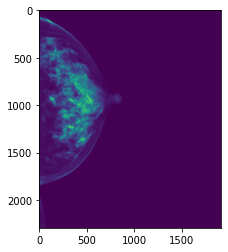

In [75]:
# img = cv2.imread(r"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000-NA-99089\1-1.dcm")
plt.imshow(procees_dcm(r"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000-NA-99089\1-1.dcm"))

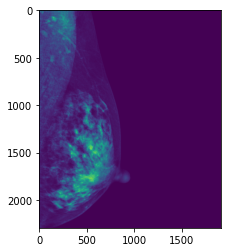

In [76]:
plt.imshow(procees_dcm(r"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000-NA-99089\1-2.dcm"))

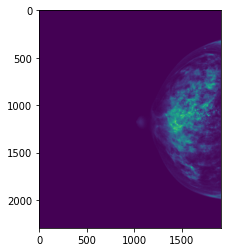

In [77]:
plt.imshow(procees_dcm(r"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000-NA-99089\1-3.dcm"))

In [ ]:
full_left = []
full_right = []
id = 0
meta_china_cancer = pd.DataFrame(columns=['patient_id', 'image_id', 'laterality', 'cancer', 'path'])  

for i in range(len(meta_china)):
    path = meta_china['File Location'][i].replace('\\', '/').replace('.', '', 1)
    # lat_cancer = meta_china.LeftRight[i]
    for p in glob.glob(f'TheChineseMammographyDatabase{path}/*.dcm'):

        dicom = pydicom.dcmread(p)
        img = dicom.pixel_array
    
            
        img = apply_windowing(img, dicom)
        img = (img - img.min()) / (img.max() - img.min())

        if dicom.PhotometricInterpretation == "MONOCHROME1":  
            img = 1 - img
        
        h, w = img.shape
        left = np.sum(img[: , : int(w/2)])
        right = np.sum(img[: , int(w/2)+1 : ])
        la = None
        if left > right: la = 'L'
        else:  la = 'R'
        tmp_cancer = ''
        if meta_china.LeftRight[i] == la and meta_china.classification[i] == 'Malignant': tmp_cancer = 1
        else: tmp_cancer = 0
        meta_china_cancer.loc[id]  = [meta_china.ID1[i], id, la, tmp_cancer,p]
        # image = np.uint8(img * 255)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # la  =meta_china_cancer['laterality'][id]
        # imageio.imwrite(f'TheChineseMammographyCancer/{id}_{meta_china.ID1[i]}_{la}.png', img)
        id+=1

# meta_china_cancer['patient_id'][1] = 1 5202 
meta_china_cancer.to_csv('TheChineseMammographyCancer/meta_china_all')
meta_china_cancer.to_csv('CMMD_1024x512foryou/meta_china_cancer')

In [29]:
ev3 =  Evaluate(sd3.meta_pro, 'Cmmd')
ev3.show()

NameError: name 'Evaluate' is not defined

In [58]:
len(glob.glob('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CDD-CESM\*.png'))

638

In [61]:
cdd = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\cdd_cesm.csv')
cdd

,Unnamed: 0,patient_id,image_id,view,laterality,cancer
0,0,1,P1&L&DM&MLO,MLO,L,1
1,1,1,P1&L&DM&MLO,CC,L,0
2,2,3,P3&R&DM&CC,CC,R,0
3,3,3,P3&R&DM&MLO,MLO,R,0
4,4,3,P3&L&DM&CC,CC,L,1
...,...,...,...,...,...,...
633,633,323,P323&L&DM&MLO,MLO,L,1
634,634,326,P326&R&DM&CC,CC,R,0
635,635,326,P326&R&DM&MLO,MLO,R,0
636,636,326,P326&L&DM&CC,CC,L,1


In [63]:
cdd.image_id = cdd.image_id.apply(lambda x: x.replace('&', '-'))
cdd

C:\Users\nguye\AppData\Local\Temp\ipykernel_23948\205232285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd.image_id = cdd.image_id.apply(lambda x: x.replace('&', '-'))


,patient_id,image_id,view,laterality,cancer
0,1,P1-L-DM-MLO,MLO,L,1
1,1,P1-L-DM-MLO,CC,L,0
2,3,P3-R-DM-CC,CC,R,0
3,3,P3-R-DM-MLO,MLO,R,0
4,3,P3-L-DM-CC,CC,L,1
...,...,...,...,...,...
633,323,P323-L-DM-MLO,MLO,L,1
634,326,P326-R-DM-CC,CC,R,0
635,326,P326-R-DM-MLO,MLO,R,0
636,326,P326-L-DM-CC,CC,L,1


In [64]:
cdd.patient_id = cdd.patient_id.apply(lambda x: str(x)+'CDD')
cdd

C:\Users\nguye\AppData\Local\Temp\ipykernel_23948\322336801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd.patient_id = cdd.patient_id.apply(lambda x: str(x)+'CDD')


,patient_id,image_id,view,laterality,cancer
0,1CDD,P1-L-DM-MLO,MLO,L,1
1,1CDD,P1-L-DM-MLO,CC,L,0
2,3CDD,P3-R-DM-CC,CC,R,0
3,3CDD,P3-R-DM-MLO,MLO,R,0
4,3CDD,P3-L-DM-CC,CC,L,1
...,...,...,...,...,...
633,323CDD,P323-L-DM-MLO,MLO,L,1
634,326CDD,P326-R-DM-CC,CC,R,0
635,326CDD,P326-R-DM-MLO,MLO,R,0
636,326CDD,P326-L-DM-CC,CC,L,1


In [62]:
cdd = cdd[[	"patient_id"	,"image_id"	,"view"	,"laterality", "cancer"]]

In [55]:
cdd.to_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\cdd_cesm.csv')

# CDD_CESM

In [23]:
meta_cdd = pd.read_csv(r"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Collect_Data\CDD_CESM_external.csv")
meta_cdd

,Unnamed: 0,image_id,patient_id,laterality,view,age,machine_id,cancer
0,0,P1_L_DM_MLO,1,L,MLO,46,1,1
1,1,P2_R_DM_CC,2,R,CC,31,2,0
2,2,P2_R_DM_MLO,2,R,MLO,31,2,0
3,3,P2_L_DM_CC,2,L,CC,31,2,0
4,4,P2_L_DM_MLO,2,L,MLO,31,2,0
...,...,...,...,...,...,...,...,...
998,998,P325_L_DM_MLO,325,L,MLO,49,1,0
999,999,P326_R_DM_CC,326,R,CC,51,1,0
1000,1000,P326_R_DM_MLO,326,R,MLO,51,1,0
1001,1001,P326_L_DM_CC,326,L,CC,51,1,1


In [24]:
meta_cdd = meta_cdd[['patient_id', 'image_id', 'view', 'laterality', 'age', 'cancer']]
meta_cdd.image_id = meta_cdd.image_id.apply(lambda x:  x.replace('_', '&'))

C:\Users\nguye\AppData\Local\Temp\ipykernel_3284\459961279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_cdd.image_id = meta_cdd.image_id.apply(lambda x:  x.replace('_', '&'))


In [25]:
meta_cdd

,patient_id,image_id,view,laterality,age,cancer
0,1,P1&L&DM&MLO,MLO,L,46,1
1,2,P2&R&DM&CC,CC,R,31,0
2,2,P2&R&DM&MLO,MLO,R,31,0
3,2,P2&L&DM&CC,CC,L,31,0
4,2,P2&L&DM&MLO,MLO,L,31,0
...,...,...,...,...,...,...
998,325,P325&L&DM&MLO,MLO,L,49,0
999,326,P326&R&DM&CC,CC,R,51,0
1000,326,P326&R&DM&MLO,MLO,R,51,0
1001,326,P326&L&DM&CC,CC,L,51,1


In [26]:
from Setting_data import *

In [60]:
cdd = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\cdd_cesm.csv')
cdd

,Unnamed: 0,patient_id,image_id,view,laterality,cancer
0,0,1,P1&L&DM&MLO,MLO,L,1
1,1,1,P1&L&DM&MLO,CC,L,0
2,2,3,P3&R&DM&CC,CC,R,0
3,3,3,P3&R&DM&MLO,MLO,R,0
4,4,3,P3&L&DM&CC,CC,L,1
...,...,...,...,...,...,...
633,633,323,P323&L&DM&MLO,MLO,L,1
634,634,326,P326&R&DM&CC,CC,R,0
635,635,326,P326&R&DM&MLO,MLO,R,0
636,636,326,P326&L&DM&CC,CC,L,1


In [27]:
sd4 = Setting_data(meta_cdd)

sd4.multi_process(meta_cdd.patient_id.unique())

# sd4.save_file('Test_data/cdd_cesm.csv')

d:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Notebook_code\Task_get_100img\Setting_data.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['id_img_zip'][i] = f'{self.data.cancer[i]}_{self.data.image_id[i]}'


[('0_P2&R&DM&CC', 31)]
[('0_P2&R&DM&MLO', 31)]
P2&R&DM&CC P2&R&DM&MLO
[('0_P2&L&DM&CC', 31)]
[('0_P2&L&DM&MLO', 31)]
P2&L&DM&CC P2&L&DM&MLO
[('0_P3&R&DM&CC', 45)]
[('0_P3&R&DM&MLO', 45)]
P3&R&DM&CC P3&R&DM&MLO
[('1_P3&L&DM&CC', 45)]
[('1_P3&L&DM&MLO', 45)]
P3&L&DM&CC P3&L&DM&MLO
[('0_P5&R&DM&CC', 51)]
[('0_P5&R&DM&MLO', 51)]
P5&R&DM&CC P5&R&DM&MLO
[('0_P5&L&DM&CC', 51)]
[('0_P5&L&DM&MLO', 51)]
P5&L&DM&CC P5&L&DM&MLO
[('0_P7&R&DM&CC', 69)]
[('0_P7&R&DM&MLO', 69)]
P7&R&DM&CC P7&R&DM&MLO
[('0_P10&R&DM&CC ', 63)]
[('0_P10&R&DM&MLO ', 63)]
P10&R&DM&CC  P10&R&DM&MLO 
[('0_P10&L&DM&CC', 63)]
[('0_P10&L&DM&MLO', 63)]
P10&L&DM&CC P10&L&DM&MLO
[('0_P11&R&DM&CC', 51)]
[('0_P11&R&DM&MLO', 51)]
P11&R&DM&CC P11&R&DM&MLO
[('0_P12&R&DM&CC', 63)]
[('0_P12&R&DM&MLO', 63)]
P12&R&DM&CC P12&R&DM&MLO
[('1_P12&L&DM&CC', 63)]
[('1_P12&L&DM&MLO', 63)]
P12&L&DM&CC P12&L&DM&MLO
[('0_P14&R&DM&CC', 56)]
[('0_P14&R&DM&MLO', 56)]
P14&R&DM&CC P14&R&DM&MLO
[('0_P14&L&DM&CC', 56)]
[('0_P14&L&DM&MLO', 56)]
P14&L&DM&CC P

In [28]:
def loc_cancer(data, name):
    df = data[data['cancer'] == 1].patient_id
    df = df.unique()
    data = data[data['patient_id'].isin(df)]
    data = data.reset_index()
    data.to_csv(f'{name}.csv')


In [87]:
loc_cancer(sd4.meta_pro, 'cdd_cesm')

In [61]:
loc_cancer(sd3.meta_pro, 'Cmmd_2')

In [62]:
df = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Notebook_code\Test_data\vindr_1.csv')
df

,Unnamed: 0,patient_id,image_id,view,laterality,age,cancer
0,0,b8d273e8601f348d3664778dae0e7e0b,cd0fc7bc53ac632a11643ac4cc91002a,CC,R,53.0,0
1,1,b8d273e8601f348d3664778dae0e7e0b,71638b1e853799f227492bfb08a01491,MLO,R,53.0,0
2,2,b8d273e8601f348d3664778dae0e7e0b,d8125545210c08e1b1793a5af6458ee2,CC,L,53.0,0
3,3,b8d273e8601f348d3664778dae0e7e0b,290c658f4e75a3f83ec78a847414297c,MLO,L,53.0,0
4,4,8269f5971eaca3e5d3772d1796e6bd7a,202d761a6b0f86faaeefc39ee18b1c53,CC,R,42.0,0
...,...,...,...,...,...,...,...
17733,17733,f2093a752e6b44df5990f5fd38c99dd2,9edcc7df8ac157fb2fdbecb9baae9f2f,MLO,L,38.0,0
17734,17734,b3c8969cd2accfa4dbb2aece1f7158ab,4689616c3d0b46fcba7a771107730791,CC,R,18.0,0
17735,17735,b3c8969cd2accfa4dbb2aece1f7158ab,d443b9725e331b8b27589aa725597801,MLO,R,18.0,0
17736,17736,b3c8969cd2accfa4dbb2aece1f7158ab,3c22491bcf1d0b004715c28d80981cdd,CC,L,18.0,0


In [33]:
cdd = pd.read_csv('cdd_cesm.csv')
cdd

,Unnamed: 0,index,patient_id,image_id,view,laterality,age,cancer
0,0,0,1,P1&L&DM&MLO,MLO,L,46,1
1,1,1,1,P1&L&DM&MLO,CC,L,46,0
2,2,6,3,P3&R&DM&CC,CC,R,45,0
3,3,7,3,P3&R&DM&MLO,MLO,R,45,0
4,4,8,3,P3&L&DM&CC,CC,L,45,1
...,...,...,...,...,...,...,...,...
633,633,927,323,P323&L&DM&MLO,MLO,L,45,1
634,634,934,326,P326&R&DM&CC,CC,R,51,0
635,635,935,326,P326&R&DM&MLO,MLO,R,51,0
636,636,936,326,P326&L&DM&CC,CC,L,51,1


In [40]:
for id_img in cdd.image_id:
    id_img = id_img.replace('&' , '_')
    img = cv2.imread(f'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\CDD-CESM\CDD-CESM\Low energy images of CDD-CESM\{id_img}.jpg')
    # print(img)
    # id_img = id_img.replace('&' , '_')
    try:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    except:
        img = img
    # id_img = id_img.replace('_' , '_')
    imageio.imwrite(f'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CDD-CESM\{id_img}.png', img)

In [34]:
from Evaluate import *

In [35]:
eval = Evaluate(cdd, 'cdd_cesm')
eval.show()

Dataset cdd_cesm 
 Số lượng image: 638 
 Số luong patient: 179
So luong CC và MLO
MLO    319
CC     319
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             164
      R             155
MLO   L             164
      R             155
dtype: int64
So luong img cancer: 331


## Check last time

In [48]:
class Evaluate:
    def __init__(self, meta_pro, name):
        self.al_data = meta_pro.reset_index()
        self.name = name
    def quatity_cc_mlo(self):
        print("So luong CC và MLO")
        print(self.al_data.view.value_counts())
    def lelf_right(self):
        print("So luong L và R")
        print(self.al_data.groupby(['view', 'laterality']).size())
    def show_one(self, par):
        print(self.al_data[self.al_data.patient_id == par])
    def quanlity_cancer(self):
        sl = len(self.al_data[self.al_data.cancer == 1])
        print(f"So luong img cancer: {sl}")
        # print(self.al_data[self.al_data.cancer == 1])
    def show(self):
        ls = len(self.al_data)
        par = len(self.al_data.patient_id.unique())
        print(f'Dataset {self.name} \n Số lượng image: {ls} \n Số luong patient: {par}')
        self.quatity_cc_mlo()
        self.lelf_right()
        self.quanlity_cancer()

RSNA

In [146]:
rsna = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Notebook_code\Test_data\rsna_7.csv')
rsna

,Unnamed: 0,patient_id,image_id,view,laterality,age,cancer
0,0,10006,1874946579,CC,R,61.0,0
1,1,10006,1864590858,MLO,R,61.0,0
2,2,10006,462822612,CC,L,61.0,0
3,3,10006,1459541791,MLO,L,61.0,0
4,4,10011,541722628,CC,R,55.0,0
...,...,...,...,...,...,...,...
50171,50171,9973,1703611570,MLO,L,43.0,0
50172,50172,9989,439796429,CC,R,60.0,0
50173,50173,9989,398038886,MLO,R,60.0,0
50174,50174,9989,1078943060,CC,L,60.0,0


In [147]:
rsna = rsna[['patient_id', 'image_id', 'view', 'laterality', 'age', 'cancer']]
rsna

,patient_id,image_id,view,laterality,age,cancer
0,10006,1874946579,CC,R,61.0,0
1,10006,1864590858,MLO,R,61.0,0
2,10006,462822612,CC,L,61.0,0
3,10006,1459541791,MLO,L,61.0,0
4,10011,541722628,CC,R,55.0,0
...,...,...,...,...,...,...
50171,9973,1703611570,MLO,L,43.0,0
50172,9989,439796429,CC,R,60.0,0
50173,9989,398038886,MLO,R,60.0,0
50174,9989,1078943060,CC,L,60.0,0


In [148]:
ev_rsna = Evaluate(rsna, 'rsna')
ev_rsna.show()

Dataset rsna 
 Số lượng image: 50176 
 Số luong patient: 11905
So luong CC và MLO
CC     25088
MLO    25088
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             12534
      R             12554
MLO   L             12534
      R             12554
dtype: int64
So luong img cancer: 1156


### Vindr

In [12]:
vindr = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Notebook_code\Test_data\Vindr_8.csv')
vindr = vindr[['patient_id', 'image_id', 'view', 'laterality', 'age', 'cancer']]
cancer = list(vindr[vindr.cancer == 1].patient_id.values)
cancer

['10200894bf6f74b2ae92a0cecd37c60c',
 '10200894bf6f74b2ae92a0cecd37c60c',
 '450f7f9b2aa32754b076f0f53f0d8efc',
 '450f7f9b2aa32754b076f0f53f0d8efc',
 'fe23c1647f7617ef219a0a0e07c9eec5',
 'fe23c1647f7617ef219a0a0e07c9eec5',
 'a0da8d047c71765cdf217a8a52606741',
 'a0da8d047c71765cdf217a8a52606741',
 'a0d75cb5a7be01a0d63f5d9ec553443e',
 'a0d75cb5a7be01a0d63f5d9ec553443e',
 '563643e06302bcd7216c2ca8de3157e5',
 '563643e06302bcd7216c2ca8de3157e5',
 'de585e55834681c650d1f34ff21c2139',
 'de585e55834681c650d1f34ff21c2139',
 '877bde1cb8b7df49cde3fdb7020a1536',
 '877bde1cb8b7df49cde3fdb7020a1536',
 'd8d0bc6e58b11efa2f86a9c0986b038e',
 'd8d0bc6e58b11efa2f86a9c0986b038e',
 'b57b97020df361371ae1877080433275',
 'b57b97020df361371ae1877080433275',
 'ad39689f1bea2e0aee2574488f06d231',
 'ad39689f1bea2e0aee2574488f06d231',
 'f637a8ea804bac3941603ae34dae7fb7',
 'f637a8ea804bac3941603ae34dae7fb7',
 '1560345de7d8277b170ca3842eae6c97',
 '1560345de7d8277b170ca3842eae6c97',
 '8dd986e8174fc84c2a984e66a416ff9f',
 

In [13]:
vindr = vindr[vindr.patient_id.isin(cancer)]

In [16]:
ev_vin = Evaluate(vindr, 'vindr')
ev_vin.show()

Dataset vindr 
 Số lượng image: 452 
 Số luong patient: 113
So luong CC và MLO
CC     226
MLO    226
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             113
      R             113
MLO   L             113
      R             113
dtype: int64
So luong img cancer: 226


In [18]:
vindr = vindr.reset_index()
vindr.to_csv('Test_data/vindr_9.csv')

### CMMD

In [35]:
cmmd = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Notebook_code\Test_data\Cmmd_2.csv')
cmmd = cmmd[['patient_id', 'image_id', 'view', 'laterality', 'age', 'cancer']]
cancer_cmmd = list(cmmd[cmmd.cancer == 1].patient_id.unique())
cancer_cmmd

['D1-0045',
 'D1-0046',
 'D1-0047',
 'D1-0051',
 'D1-0053',
 'D1-0055',
 'D1-0056',
 'D1-0058',
 'D1-0059',
 'D1-0061',
 'D1-0063',
 'D1-0064',
 'D1-0067',
 'D1-0068',
 'D1-0070',
 'D1-0071',
 'D1-0075',
 'D1-0078',
 'D1-0084',
 'D1-0085',
 'D1-0087',
 'D1-0089',
 'D1-0091',
 'D1-0101',
 'D1-0102',
 'D1-0103',
 'D1-0105',
 'D1-0106',
 'D1-0107',
 'D1-0110',
 'D1-0111',
 'D1-0112',
 'D1-0113',
 'D1-0116',
 'D1-0120',
 'D1-0121',
 'D1-0122',
 'D1-0124',
 'D1-0127',
 'D1-0129',
 'D1-0130',
 'D1-0131',
 'D1-0132',
 'D1-0133',
 'D1-0134',
 'D1-0135',
 'D1-0140',
 'D1-0142',
 'D1-0143',
 'D1-0147',
 'D1-0148',
 'D1-0149',
 'D1-0152',
 'D1-0154',
 'D1-0157',
 'D1-0161',
 'D1-0162',
 'D1-0163',
 'D1-0168',
 'D1-0169',
 'D1-0171',
 'D1-0173',
 'D1-0176',
 'D1-0178',
 'D1-0180',
 'D1-0181',
 'D1-0182',
 'D1-0183',
 'D1-0184',
 'D1-0188',
 'D1-0189',
 'D1-0191',
 'D1-0192',
 'D1-0194',
 'D1-0196',
 'D1-0199',
 'D1-0200',
 'D1-0201',
 'D1-0202',
 'D1-0203',
 'D1-0204',
 'D1-0207',
 'D1-0208',
 'D1

In [38]:
cmmd

,patient_id,image_id,view,laterality,age,cancer
0,D1-0045,D1-0045&1-2,CC,L,33,1
1,D1-0045,D1-0045&1-1,MLO,L,33,1
2,D1-0046,D1-0046&1-2,CC,R,43,1
3,D1-0046,D1-0046&1-1,MLO,R,43,1
4,D1-0047,D1-0047&1-2,CC,R,43,1
...,...,...,...,...,...,...
4289,D2-0748,D2-0748&1-1,MLO,R,29,0
4290,D2-0749,D2-0749&1-2,CC,L,42,1
4291,D2-0749,D2-0749&1-1,MLO,L,42,1
4292,D2-0749,D2-0749&1-4,CC,L,42,0


In [37]:
cmmd.patient_id.unique()

array(['D1-0045', 'D1-0046', 'D1-0047', ..., 'D2-0747', 'D2-0748',
       'D2-0749'], dtype=object)

In [34]:
len(cmmd.patient_id.unique())

1310

In [36]:
len(cancer_cmmd)

1310

In [26]:
cmmd = cmmd[cmmd.patient_id.isin(cancer_cmmd)]

In [27]:
ev_cmmd = Evaluate(cmmd, 'CMMD')
ev_cmmd.show()

Dataset CMMD 
 Số lượng image: 4294 
 Số luong patient: 1310
So luong CC và MLO
CC     2147
MLO    2147
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             1133
      R             1014
MLO   L             1133
      R             1014
dtype: int64
So luong img cancer: 2633


### CDD-CESM

In [49]:
CDD = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Notebook_code\Test_data\cdd_cesm_3.csv')
CDD = CDD[['patient_id', 'image_id', 'view', 'laterality', 'age', 'cancer']]
CDD

,patient_id,image_id,view,laterality,age,cancer
0,1,P1&L&DM&MLO,MLO,L,46,1
1,1,P1&L&DM&MLO,CC,L,46,0
2,3,P3&R&DM&CC,CC,R,45,0
3,3,P3&R&DM&MLO,MLO,R,45,0
4,3,P3&L&DM&CC,CC,L,45,1
...,...,...,...,...,...,...
633,323,P323&L&DM&MLO,MLO,L,45,1
634,326,P326&R&DM&CC,CC,R,51,0
635,326,P326&R&DM&MLO,MLO,R,51,0
636,326,P326&L&DM&CC,CC,L,51,1


In [50]:
ev_CDD = Evaluate(CDD, 'CDD')
ev_CDD.show()

Dataset CDD 
 Số lượng image: 638 
 Số luong patient: 179
So luong CC và MLO
MLO    319
CC     319
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             164
      R             155
MLO   L             164
      R             155
dtype: int64
So luong img cancer: 331


In [111]:
cmmd.groupby(['patient_id'])['image_id'].count().value_counts()

4    140
2     39
Name: image_id, dtype: int64

In [115]:
rsna = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Collect_Data\rsna.csv')

In [116]:
rsna.groupby(['patient_id'])['image_id'].count().value_counts()

4     8233
5     1767
6     1218
7      276
8      229
9       99
10      53
11      19
12      12
13       5
14       2
Name: image_id, dtype: int64

In [119]:
meta_vindr

,study_id,image_id,view_position,laterality,breast_birads,age
0,b8d273e8601f348d3664778dae0e7e0b,d8125545210c08e1b1793a5af6458ee2,CC,L,0,53.0
1,b8d273e8601f348d3664778dae0e7e0b,290c658f4e75a3f83ec78a847414297c,MLO,L,0,53.0
2,b8d273e8601f348d3664778dae0e7e0b,cd0fc7bc53ac632a11643ac4cc91002a,CC,R,0,53.0
3,b8d273e8601f348d3664778dae0e7e0b,71638b1e853799f227492bfb08a01491,MLO,R,0,53.0
4,8269f5971eaca3e5d3772d1796e6bd7a,dd9ce3288c0773e006a294188aadba8e,CC,L,0,42.0
...,...,...,...,...,...,...
19995,f2093a752e6b44df5990f5fd38c99dd2,ea732154d149f619b20070b78060ae65,CC,R,0,38.0
19996,b3c8969cd2accfa4dbb2aece1f7158ab,4689616c3d0b46fcba7a771107730791,CC,R,0,18.0
19997,b3c8969cd2accfa4dbb2aece1f7158ab,3c22491bcf1d0b004715c28d80981cdd,CC,L,0,18.0
19998,b3c8969cd2accfa4dbb2aece1f7158ab,d443b9725e331b8b27589aa725597801,MLO,R,0,18.0


In [128]:
meta_vindr.groupby(['patient_id'])['image_id'].count().value_counts()

4    5000
Name: image_id, dtype: int64

In [133]:
meta_cmmd.groupby(['patient_id'])['image_id'].count().value_counts()

2    949
4    729
8     97
Name: image_id, dtype: int64

In [137]:
meta_cdd.groupby(['patient_id'])['image_id'].count().value_counts()

4    191
1     62
2     46
3     25
5      2
Name: image_id, dtype: int64

RENAME

In [24]:
cdd = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD.csv')
cdd

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,patient_id,image_id,view,laterality,cancer
0,0,0,0,D1-0045,D1-0045_1-2,CC,L,1
1,1,1,1,D1-0045,D1-0045_1-1,MLO,L,1
2,2,2,2,D1-0046,D1-0046_1-2,CC,R,1
3,3,3,3,D1-0046,D1-0046_1-1,MLO,R,1
4,4,4,4,D1-0047,D1-0047_1-2,CC,R,1
...,...,...,...,...,...,...,...,...
2687,2687,2687,2687,D2-0747,D2-0747_1-3,MLO,R,1
2688,2688,2688,2688,D2-0748,D2-0748_1-4,CC,R,1
2689,2689,2689,2689,D2-0748,D2-0748_1-3,MLO,R,1
2690,2690,2690,2690,D2-0749,D2-0749_1-2,CC,L,1


In [26]:
cdd

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,patient_id,image_id,view,laterality,cancer
0,0,0,0,D1-0045,D1-0045_1-2,CC,L,1
1,1,1,1,D1-0045,D1-0045_1-1,MLO,L,1
2,2,2,2,D1-0046,D1-0046_1-2,CC,R,1
3,3,3,3,D1-0046,D1-0046_1-1,MLO,R,1
4,4,4,4,D1-0047,D1-0047_1-2,CC,R,1
...,...,...,...,...,...,...,...,...
2687,2687,2687,2687,D2-0747,D2-0747_1-3,MLO,R,1
2688,2688,2688,2688,D2-0748,D2-0748_1-4,CC,R,1
2689,2689,2689,2689,D2-0748,D2-0748_1-3,MLO,R,1
2690,2690,2690,2690,D2-0749,D2-0749_1-2,CC,L,1


In [39]:
cdd.to_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD.csv')

In [29]:
for i in range(len(cdd)):
    path1 = f"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\{cdd.view[i]}_{cdd.image_id[i].replace('_', '&')}.png"
    path2 = f"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\{cdd.view[i]}_{cdd.image_id[i]}.png"
    # os.rename(path1, path2)
    if os.path.exists(path1) :
        os.rename(path1, path2)

    print(path1)

D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\CC_D1-0045&1-2.png
D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\MLO_D1-0045&1-1.png
D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\CC_D1-0046&1-2.png
D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\MLO_D1-0046&1-1.png
D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\CC_D1-0047&1-2.png
D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\MLO_D1-0047&1-1.png
D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD\CC_D1-0051&1-2.png
D:\

In [1]:
## Danh gia 

In [14]:
rsna = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\RSNA.csv')
vindr = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\Vindr.csv')
cdd = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\cdd_cesm.csv')
cmmd = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Meta_Image_origin\CMMD.csv')


In [8]:
from Evaluate import *

In [7]:
print(rsna[:2])

   Unnamed: 0  index  patient_id    image_id view laterality   age  cancer
0           0      0       10006  1874946579   CC          R  61.0       0
1           1      1       10006  1864590858  MLO          R  61.0       0


In [10]:
val1 = Evaluate(rsna, 'rsna')
val1.show()

Dataset rsna 
 Số lượng image: 49936 
 Số luong patient: 11905
So luong CC và MLO
CC     24968
MLO    24968
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             12470
      R             12498
MLO   L             12470
      R             12498
dtype: int64
So luong img cancer: 1036


In [11]:
val2 = Evaluate(vindr, 'vindr')
val2.show()

Dataset vindr 
 Số lượng image: 452 
 Số luong patient: 113
So luong CC và MLO
CC     226
MLO    226
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             113
      R             113
MLO   L             113
      R             113
dtype: int64
So luong img cancer: 226


In [16]:
val3 = Evaluate(cdd, 'cdd')
val3.show()

Dataset cdd 
 Số lượng image: 638 
 Số luong patient: 179
So luong CC và MLO
MLO    319
CC     319
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             164
      R             155
MLO   L             164
      R             155
dtype: int64
So luong img cancer: 331


In [17]:
val4 = Evaluate(cmmd, 'CMMD')
val4.show()

Dataset CMMD 
 Số lượng image: 2692 
 Số luong patient: 1310
So luong CC và MLO
CC     1346
MLO    1346
Name: view, dtype: int64
So luong L và R
view  laterality
CC    L             721
      R             625
MLO   L             721
      R             625
dtype: int64
So luong img cancer: 2632


In [20]:
2692 + 638 +452 +49936 

53718

In [21]:
meta  = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Data_main\CSV_MAIN\meta_data.csv')

In [22]:
meta

,Unnamed: 0,patient_id,image_id,view,laterality,age,cancer
0,0,10006,1874946579,CC,R,61.0,0
1,1,10006,1864590858,MLO,R,61.0,0
2,2,10006,462822612,CC,L,61.0,0
3,3,10006,1459541791,MLO,L,61.0,0
4,4,10011,541722628,CC,R,55.0,0
...,...,...,...,...,...,...,...
55079,55555,323CDD,P323-L-DM-MLO,MLO,L,45.0,1
55080,55556,326CDD,P326-R-DM-CC,CC,R,51.0,0
55081,55557,326CDD,P326-R-DM-MLO,MLO,R,51.0,0
55082,55558,326CDD,P326-L-DM-CC,CC,L,51.0,1


In [23]:
53718 - 55084

-1366